In [1]:
# Importing Libraries
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from matplotlib.image import imread as mp_imread

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

from sklearn.model_selection import train_test_split


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Data Paths
train_data_path = 'C:/jan/Combined Dataset/train'
test_data_path = 'C:/jan/Combined Dataset/test'


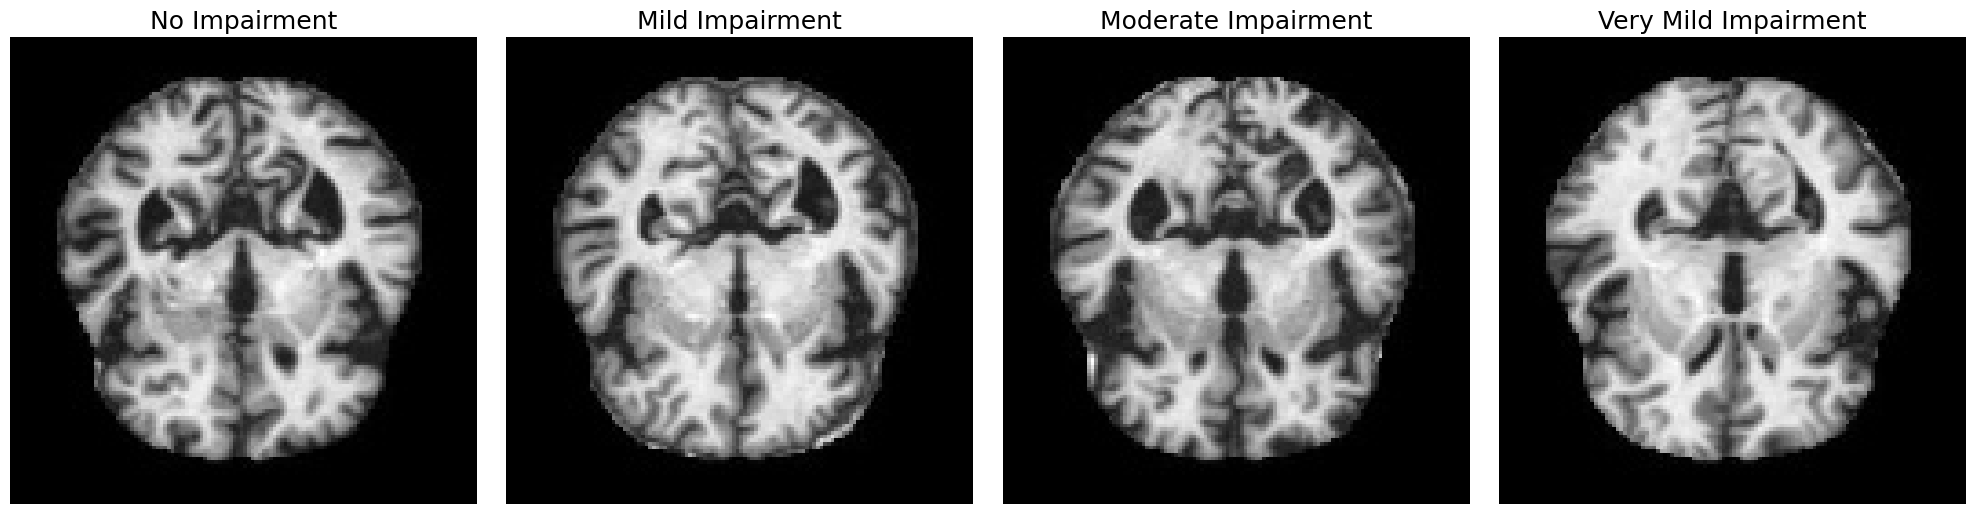

Image Shape: (128, 128, 3)


In [ ]:
# Visualizing MRI Images

# Load sample images from each category
no_impairment = mp_imread(os.path.join(train_data_path,"No Impairment","NoImpairment (1).jpg"))
mild_impairment = mp_imread(os.path.join(train_data_path,"Mild Impairment","MildImpairment (1).jpg"))
moderate_impairment = mp_imread(os.path.join(train_data_path,"Moderate Impairment","ModerateImpairment (1).jpg"))
very_mild_impairment = mp_imread(os.path.join(train_data_path,"Very Mild Impairment","VeryMildImpairment (1).jpg"))

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
titles = ['No Impairment', 'Mild Impairment', 'Moderate Impairment', 'Very Mild Impairment']
images = [no_impairment, mild_impairment, moderate_impairment, very_mild_impairment]

for idx, ax in enumerate(axes):
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(titles[idx], fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Display the shape of a sample image using OpenCV
random_image_path = os.path.join(train_data_path,"No Impairment","NoImpairment (1).jpg")
print("Image Shape:", cv2.imread(random_image_path).shape)


In [ ]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_preprocessing(output_size, val_split=0.1):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=val_split,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=output_size,
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=output_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=output_size,
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

# Set output image size
output_size = (224, 224)

# Call the function
train_generator, validation_generator, test_generator = data_preprocessing(output_size)


Found 9216 images belonging to 4 classes.
Found 1024 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# Model Building
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model without the top layer
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in vgg.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    vgg,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: No Impairment, Very Mild, Mild, Moderate
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator
)


c:\Users\HP\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 1179s 4s/step - accuracy: 0.3990 - loss: 1.5357 - val_accuracy: 0.6631 - val_loss: 0.8533
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.5139 - loss: 1.0351 - val_accuracy: 0.7090 - val_loss: 0.7333
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 796s 3s/step - accuracy: 0.5553 - loss: 0.9447 - val_accuracy: 0.7461 - val_loss: 0.6261
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.5525 - loss: 0.9320 - val_accuracy: 0.7041 - val_loss: 0.6015
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy: 0.5706 - loss: 0.9327 - val_accuracy: 0.7461 - val_loss: 0.7017
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 959s 3s/step - accuracy: 0.5817 - loss: 0.8949 - val_accuracy: 0.6982 - val_loss: 0.5992
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 934s 3s/step - accuracy: 0.5816 - loss: 0.8755 - val_accuracy: 0.7334 - val_loss: 0.6185
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 880s 3s/step - accuracy: 0.5929 - loss: 0.8680 - val_acc

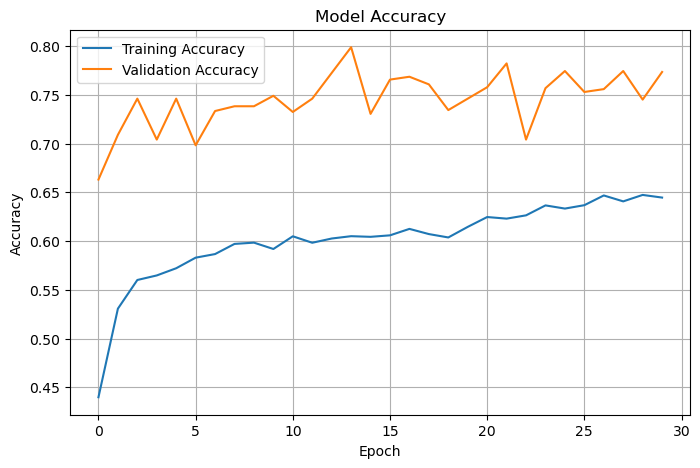

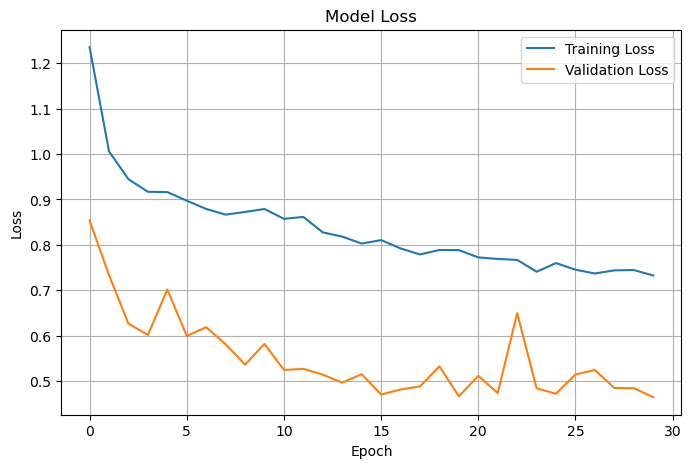

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Evaluation on Test Set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6756 - loss: 0.6950
Test Accuracy: 66.22%
Test Loss: 0.7124


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


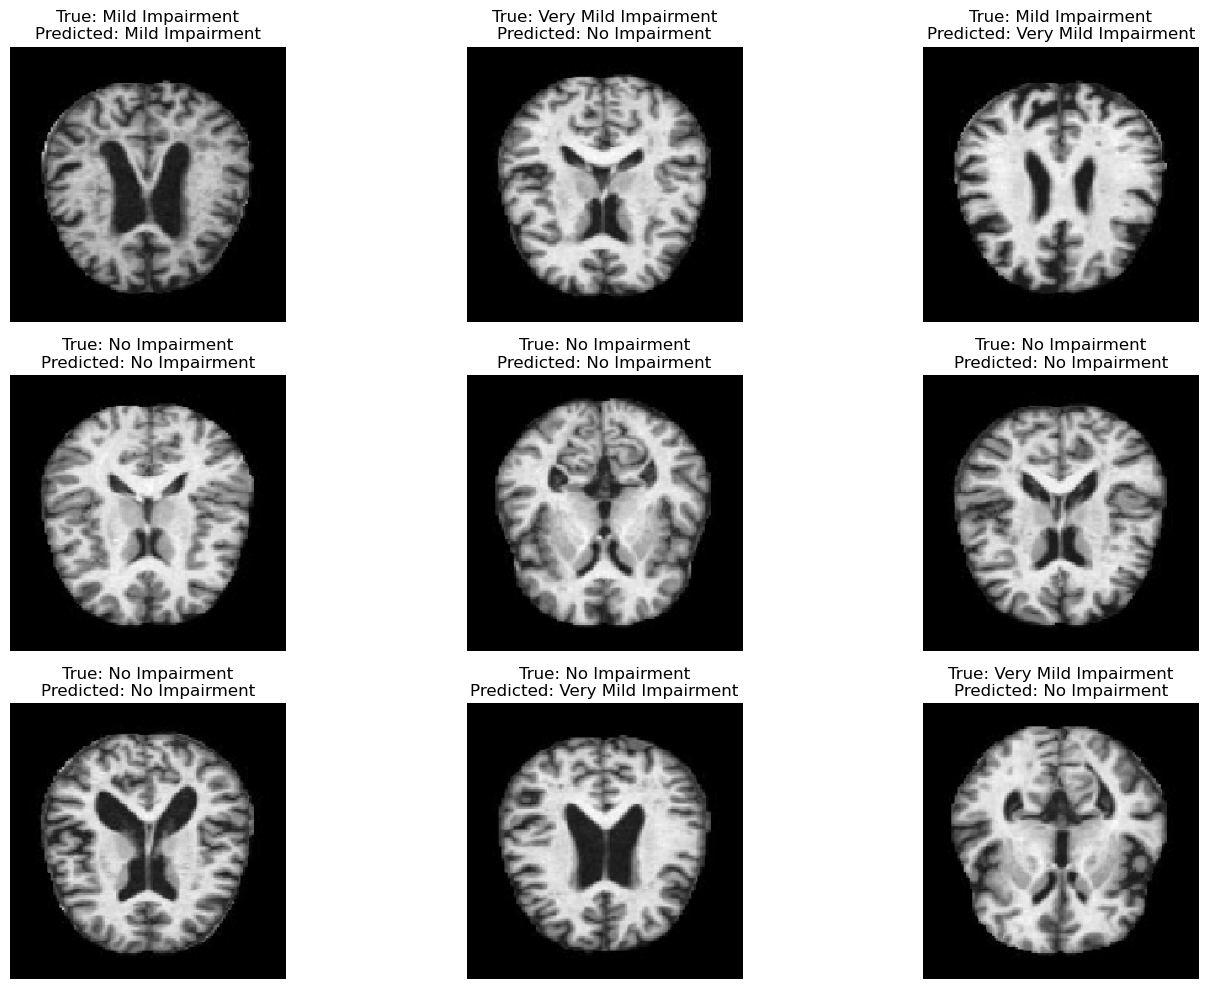

In [ ]:
# Predictions on Test Set
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

test_images, test_labels = next(test_generator)
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_labels[true_classes[i]]}\nPredicted: {class_labels[predicted_classes[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Saving the Model
from keras.saving import save_model

# Save using the recommended Keras format
model.save("alzheimer_model.keras")
save_model(model, "alzheimer_model.keras")


In [ ]:
# Loading the Model
model = tf.keras.models.load_model("alzheimer_model.keras", compile=False)


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
print(model.input_shape)


(None, 224, 224, 3)


In [ ]:
img_size = (224, 224)  # instead of (150, 150)


Model expects input shape: (None, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
Predicted Class: Moderate Impairment (85.71% confidence)


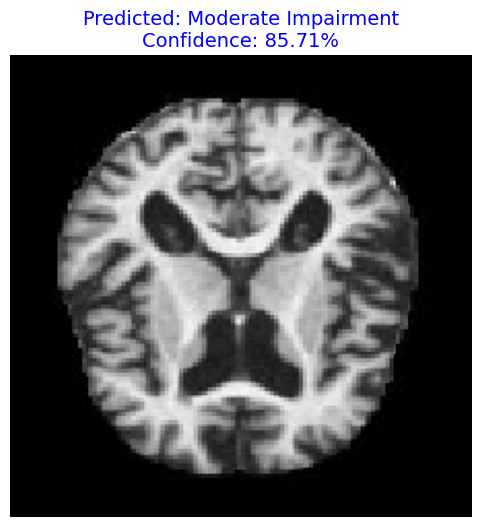

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model("alzheimer_model.keras", compile=False)
print("Model expects input shape:", model.input_shape)

# Set image size based on model's input
img_size = (224, 224)  # Model expects this size

# Class labels
class_labels = ["Mild Impairment", "Moderate Impairment", "No Impairment", "VeryMild Impairment"]

# Path to test image
image_path="C:/jan/Combined Dataset/test/ModerateImpairment/14.jpg"
# Load and preprocess the image
try:
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension: (1, 224, 224, 3)
    img_array = img_array.astype('float32') / 255.0      # Normalize
except Exception as e:
    print(f"Error loading image: {e}")
    exit()

# Predict
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = np.max(predictions) * 100

# Display result
print(f"Predicted Class: {predicted_class} ({confidence:.2f}% confidence)")
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=14, color='blue')
plt.show()


In [ ]:
print("Prediction probabilities:", predictions[0])


Prediction probabilities: [8.2750902e-02 1.2560480e-11 4.3143883e-01 4.8581025e-01]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# If saved earlier:
from tensorflow.keras.models import load_model
model = load_model("alzheimer_model.keras", compile=False)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory="C:/jan/Combined Dataset/test",
    target_size=(224, 224),  # or your model input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1279 images belonging to 4 classes.


c:\Users\HP\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step


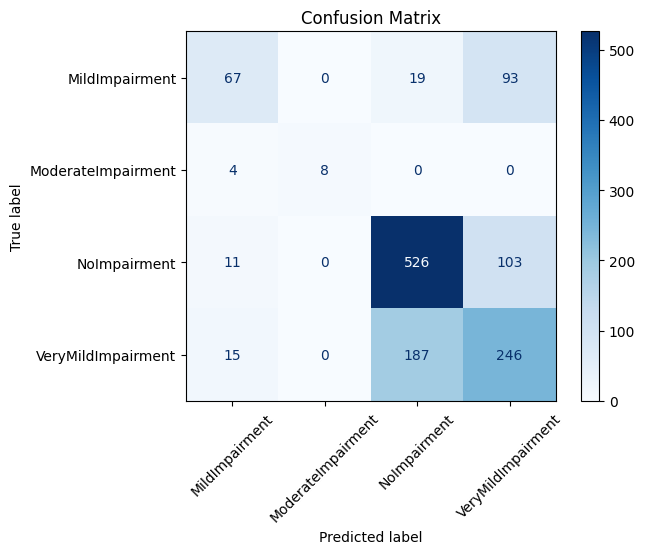

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
